In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy, get_roc_auc, get_class_ratios

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/cardiovascular/cardio.csv",sep=";")
data = data.drop(columns=['id'])
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data.shape

(70000, 12)

In [5]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [6]:
target = 'cardio'

In [7]:
X = data.drop(columns=[target])
y = data[target]

In [45]:
#model_ctgan = CTGANSynthesizer(epochs=20)
model_ctgan = DPCTGANSynthesizer(verbose=True, epochs=20)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 3
Epoch 1, Loss G: -0.7520, Loss D:  0.0026, Epsilon: 1.5110
Epoch 2, Loss G: -0.6300, Loss D: -0.0053, Epsilon: 1.5828
Epoch 3, Loss G:  0.3734, Loss D: -0.2849, Epsilon: 1.6547
Epoch 4, Loss G: -0.5047, Loss D: -0.0983, Epsilon: 1.7266
Epoch 5, Loss G: -0.3440, Loss D: -0.1608, Epsilon: 1.7984
Epoch 6, Loss G: -0.5799, Loss D: -0.0453, Epsilon: 1.8703
Epoch 7, Loss G: -0.4906, Loss D:  0.0175, Epsilon: 1.9422
Epoch 8, Loss G: -0.7036, Loss D:  0.1078, Epsilon: 2.0140
Epoch 9, Loss G: -0.1291, Loss D: -0.0491, Epsilon: 2.0859
Epoch 10, Loss G: -0.7655, Loss D:  0.0609, Epsilon: 2.1578
Epoch 11, Loss G: -0.1601, Loss D: -0.1985, Epsilon: 2.2296
Epoch 12, Loss G: -0.7061, Loss D:  0.0810, Epsilon: 2.3015
Epoch 13, Loss G: -0.4841, Loss D: -0.1760, Epsilon: 2.3734
Epoch 14, Loss G: -0.4586, Loss D:  0.0860, Epsilon: 2.4423
Epoch 15, Loss G: -0.6909, Loss D:  0.1146, Epsilon: 2.4993
Epoch 16, Loss G: -0.1260, Loss D: -0.1012, Epsilon:

In [46]:
from utils.utils import save_models
save_models(model_ctgan, 'dpctgan3', 'cardio')

In [9]:
from utils.utils import load_models
model_ctgan = load_models('dpctgan20', 'cardio')

In [10]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [11]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [12]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.01600198]


## Fidelity

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = False)

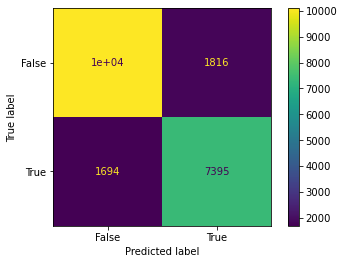

In [14]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [15]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [16]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.7346666666666667
Accuracy of synthetic data:  0.6847619047619048


In [17]:
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.7349194722223787
ROC AUC of synthetic data:  0.6849924432971091


In [18]:
ratio_class1, ratio_class2 = get_class_ratios(rr_pred, fr_pred, target)

0.7420066152149944 0.6781292984869326


## Final plot

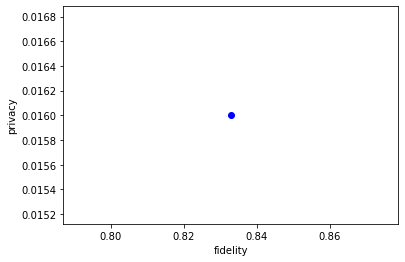

0.8328571428571429 [0.01600198]


In [19]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)